# Discussão de casos: Watershed

## Introdução
Este notebook tem por objetivo realizar a análise de casos de sucesso e falha da aplicação do método Watershed de segmentação no contexto de segmentação assistida para imagens de ressonância magnética, no problema descrito no [inserrir notebook]. Dado o procedimento individual demonstrado no [inserir notebook], será executado ao longo deste notebook o processo de execução em *batch* para um determinado escopo de *slices* de um paciente. Adicionalmente, serão discutidos os casos de falha e sucesso das execuções, com uma análise sobre as motivações dos respectivos resultados.

O roteiro de execução se dá como segue:

* O usuário tendo em mãos um paciente, localiza a lesão de interesse em um determinado `slice` da aquisição MRI;
* Neste `slice` em específico, o usuário deve realizar as operações necessárias para a execução do processo de segmentação, isto é, definir possíveis passos de pré-processamento, seus respectivos parâmetros, e demais etapas necessárias para obter-se uma segmentação bem-sucedida da lesão;
* Tendo-se uma imagem preprocessada, o usuário deve definir dois marcadores (_seeds_): uma para a região da lesão de interesse; e uma segundo, numa região externa a lesão, porém pertencente a região interna do cérebro;
* Em seguida, o usuário executa a etapa referente ao procedimento de segmentação propriamente dito, com o método Watershed;
* Dada uma segmentação exitosa, o usuário então informa um escopo de slices, precedentes, posteriores, ou ambos, para o qual o método deve segmentar usando os mesmos parâmetros e ordem de etapas realizados no `slice` de referência.


O objetivo é que, tendo uma segmentação de boa qualidade para um `slice` referência, os mesmos procedimentos possam ser executados em `slices` adjacentes, auxiliando no processo de segmentação em sequência. 

Ao todo foram analisados 4 casos de teste distintos, variando entre 6 a 9 slices em cada, totalizando juntamente um total de 31 slices. Os casos de teste possuem diferentes níveis de dificuldade para a segmentação, tanto em tamanho das regiões a serem segmentadas, como em complexidade das formas. 

Para as execuções apresentadas nesse notebook, cada caso de teste foi executado individualmente e os preprocessamentos e sementes foram definidas para o `slice` de referência. Desta forma, e etapa de exploração a ser executada pelo usuário já foi efetuada e aqui reproduzimos os resultados posteriores a esse processo. 

### Desenvolvimento

Inicialmente, é realizada a importação das bibliotecas numpy, math e matplotlib, juntamente com os arquivos `utils` e `watershed`, que implementam métodos utilitários e os métodos necessários para execução do watershed

In [32]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

from src import utils
from src import watershed
from src import args_test
import numpy as np
import matplotlib.pyplot as plt
import math


Inicialmente, definimos uma função para recuperar _slices_ sequenciais de um mesmo paciente. Para tanto, deve ser informado o paciente desejado, o escopo de _slices_ desejado e a perspectiva dos mesmos. Ao final, a função retorna um _array_ com todas as sequências prontas para uso pelo método de segmentação.

O método para obtenção dos _slices_ em _batch_ também pode ser configurado para retornar as máscaras, definindo-se a flag `masks` para `True`. As máscaras retornadas pelo método foram criadas por um humano e são definidas como _groundtruth_ durante as avaliações.

In [33]:
def get_batch_data(df, subject_id, slices_range, perspective, masks=False):
    start_slice, end_slice = slices_range
    slices_array = []
    for n_slice in range(start_slice, end_slice):
        slice_n = utils.get_image(df, subject_id, n_slice, perspective, masks)
        slices_array.append(np.flip(slice_n))

    return slices_array

O método a seguir realiza a execução em sequência do método Watershed para o conjunto de _slices_ obtidos por meio do método `get_batch_data` descrito anteriormente. Além da execução do método de segmentação, a função também executa os pré-processamentos necessários, por meio do argumento `morph_args`. 

In [34]:
def apply_batch_watershed(df, subject_id, slices_range, perspective, norm_thres,
                          morph_args, x, y, outer_x, outer_y, n_case):

    slices_array = get_batch_data(df, subject_id, slices_range, perspective)
    masks_array = get_batch_data(df, subject_id, slices_range, perspective, True)
    mri_norm_array = []
    mask = [[x, y], [outer_x, outer_y]]
    seg_masks_array = []
    preprocessed_mri = []
    dice_scores = []

    for slice, gt_mask in zip(slices_array, masks_array):
        mri_norm = utils.normalize_img(slice)
        mri_thresholded = mri_norm.copy()

        if norm_thres:
            mri_thresholded[mri_thresholded >= norm_thres] = 255

        mri_denoised = watershed.apply_morphology(mri_thresholded, **morph_args)
        img_seg = watershed.apply_watershed(mri_denoised, mask)
        img_seg[img_seg != 2] = 0
        img_seg[img_seg == 2] = 1

        dice_score = dice_score_similarity(img_seg, gt_mask, 1)
        dice_scores.append(dice_score)
        mri_norm_array.append(mri_norm)
        preprocessed_mri.append(mri_denoised)
        seg_masks_array.append(img_seg)

    resulting_slices = [mri_norm_array, seg_masks_array, masks_array] 
    plot_mosaic(resulting_slices, slices_range, f'CASE {n_case} - Results')
    #plot_mosaic(masks_array, slices_range, f'CASE {n_case} - Ground-Truth masks')

    return (resulting_slices, preprocessed_mri), np.asarray(dice_scores)

Como dito anteriormente, o método acima automatiza os seguintes processos, para cada caso de testes:
   * Obtenção do conjunto de `slices` de um determinado paciente;
   * Execução, para cada `slice`, das etapas de pré-processamento pré-definidas;
   * Execução da segmentação watershed na imagem pré-processada
   * Avaliação por meio da métrica _dice score_ de similaridade entre a máscara gerada pelo método de segmentação e a máscara _groundtruth_;
   * Por fim, geração de mosaico com todas as segmentações obtidas e as máscaras _groundtruth_ para avaliação visual dos resultados

In [35]:
def plot_mosaic(slices_array, slice_range, title):
    '''
    Function to plot (or save) a mosaic with all slices masks

    Params:
        slices_array: Array with all slices masks to be plotted
        slice_range: Range of slices to calculate the grid of the mosaic
        title: String title of the mosaic plot
    '''
    mri_slice = slices_array[0]
    seg_mask_array = slices_array[1]
    gt_mask_array = slices_array[2]
    
    start_slice, end_slice = slice_range
    n_cols = 3
    n_rows = math.ceil((end_slice - start_slice)) # / n_cols)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 50))
    fig.suptitle(title)
    i = 0
    slice_count = 0
    for mri, seg, gt in zip(mri_slice, seg_mask_array, gt_mask_array):
        ax = plt.subplot(n_rows, n_cols, i+1)
        ax.title.set_text(f'Slice {start_slice + slice_count} - MRI')
        plt.imshow(mri, cmap='gray')
        ax = plt.subplot(n_rows, n_cols, i+2)
        ax.title.set_text(f'Slice {start_slice + slice_count} - Watershed')
        plt.imshow(mri, cmap='gray')
        plt.imshow(seg, cmap='inferno', alpha=0.7)
        ax = plt.subplot(n_rows, n_cols, i+3)
        ax.title.set_text(f'Slice {start_slice + slice_count} - GT')
        plt.imshow(mri, cmap='gray')
        plt.imshow(gt, cmap='inferno', alpha=0.7)
        i += 3
        slice_count += 1
    plt.savefig(title)

    
def dice_score_similarity(prev_seg, bg_mask, value_mask=1):
    '''
    Calculate the dice score similarity between a groundtruth mask and a mask 
    result from a segmentation process. The dice score returns values in range
    (0, 1), being 1 total similarity and 0 total disimilarity

    Params:
        prev_seg: A segmentation result from a segmentation algorithm
        gt_mask: A groundtruth mask
        value_mask: The value of the pixels that are contained in the segmentation
                    mask

    Returns:
        The dice score similarity value between the masks
    '''
    dice_score = np.sum(prev_seg[bg_mask == value_mask]) * 2.0
    dice_score /= (np.sum(prev_seg) + np.sum(bg_mask))
    return dice_score


Por fim, os métodos para construção do mosaico de imagens e avaliação por meio do índice _dice_ de similaridade são definidos a seguir 

### Execução

Primeiramente, construímos o conjunto de dados, de maneira similar ao realizado no [inserrir notebook]. Em seguida, carregamos os casos de teste definidos no arquivo `args_teste`

In [36]:
df = utils.build_dataframe('../Episurg', 'subjects.csv')

CASES = args_test_watershed.TESTE_CASES
dices_scores_watershed = []
n_case = 1
res_dict = {}

### Caso de teste Nº 1

O caso de teste 1 é referente a uma pequena área removida na parte frontal do cérebro. A região apresenta tamanho inicialmente crescente nos primeiros _slices_, mas posteriormente se estabiliza e permanece em um tamanho semelhante até o último _slice_ utilizado neste teste. Neste caso de teste, previamente ao processo de segmentação, foram executados dois pré-processamentos: remoção de ruído com filtro de mediana e filtro para cálculo de gradiente. Para o caso de testes 1, o _slice_ de Nº 176 foi utilizado como referência para definição dos preprocessamentos, seus parâmetros e das _seeds_.

O caso de teste 1 e os demais parâmetros são exibidos a seguir:

In [37]:
n_case = 0
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
norm_thres = case_test['norm_thres']
morphy = case_test['apply_morphy']
x = case_test['x']
y = case_test['y']
outer_x = case_test['outer_mark_x']
outer_y = case_test['outer_mark_y']

print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Threshold de pré-processamento: {norm_thres}')
print(f'Pré-processamentos definidos e seus respectivos parametros:')
for key in morphy:
    print(f'   Pré-processamento: {key}')
    print(f'   Parametros:\n    {morphy[key]}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')
print(f'Coordanada X da semente externa: {outer_x}')
print(f'Coordanada Y da semente: {outer_y}')

Id do Subject: 0018
Intervalo de slices: (173, 182)
Perspectiva dos slices: a
Threshold de pré-processamento: None
Pré-processamentos definidos e seus respectivos parametros:
   Pré-processamento: denoise_1
   Parametros:
    {'method': <function median at 0x7f494062b280>, 'se': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)}
   Pré-processamento: gradient_1
   Parametros:
    {'method': <function gradient at 0x7f49405ffca0>, 'se': array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)}
Coordanada X da semente: 116
Coordanada Y da semente: 85
Coordanada X da semente externa: 109
Coordanada Y da semente: 99


Os resultados das máscaras de segmentação, e ao lado o comparativo dos _groundtruth_ humanos são apresentados no mosaico a seguir, sendo cada linha representativa a um _slice_ da sequência e as colunas a imagem de MRI, a máscara de segmentação watershed, e a máscara _groundtruth_, respectivamente.

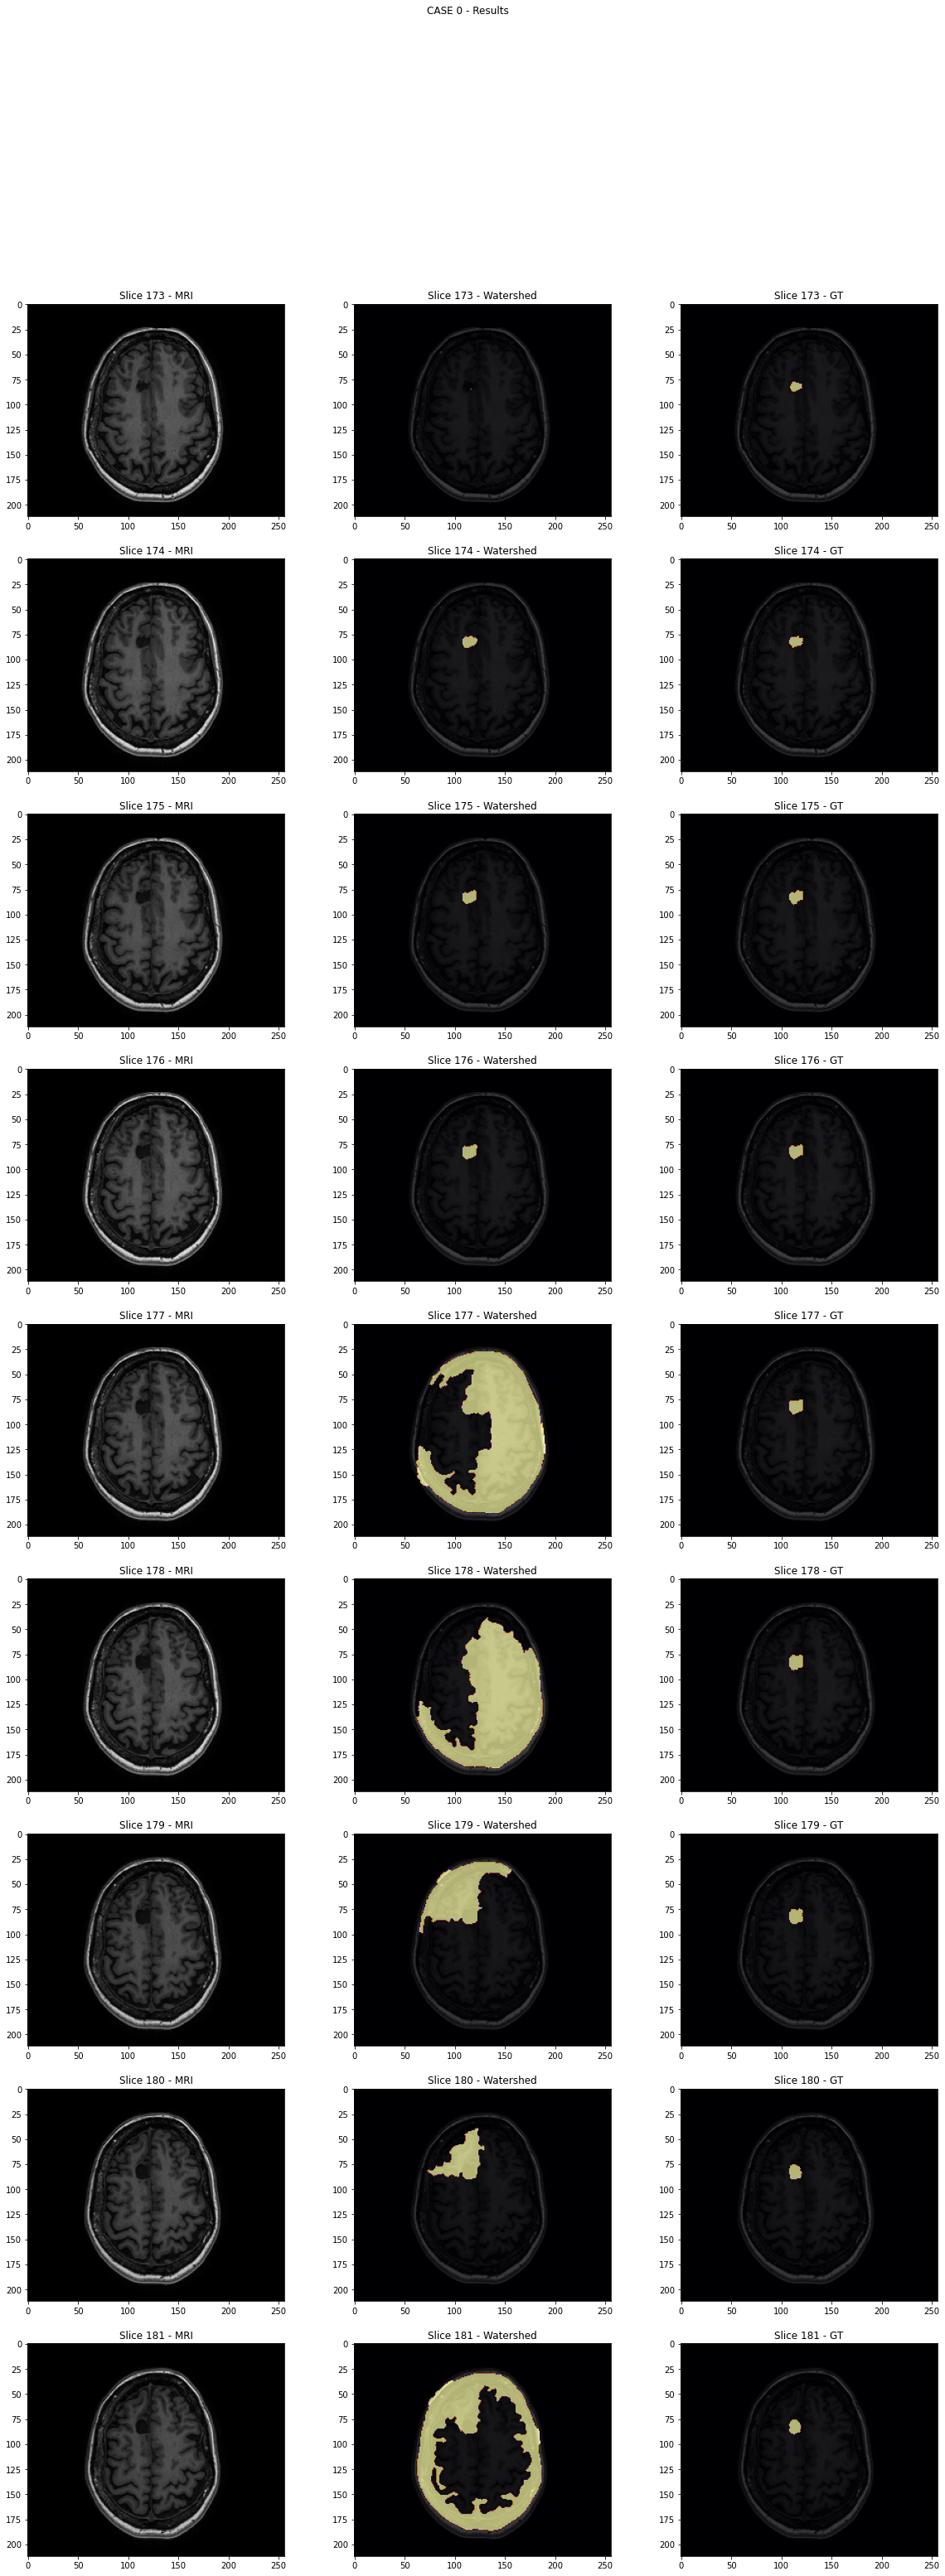

In [38]:
res_dict = {}
slices_result, dices_water = apply_batch_watershed(df, sub_id, slices_range,
                                    perspective, norm_thres, morphy, x,
                                    y, outer_x, outer_y, n_case)
dices_scores_watershed.append(dices_water)
res_dict[f'CASE{n_case}'] = {'watershed': dices_water}


Como é possível observar, o modelo conseguiu realizar boas segmentações nos _slices_ anteriores ao utilizado como referência (_slice_ 176), conseguindo segmentações muito próximas ao _groundtruth_. Contudo, nos _slices_ posteriores o modelo apresentou problemas, tendo as segmentações vazados para outras regiões do cérebro, fora da lesão desejada. Para fins de análise, vamos observar o resultado da imagem preprocessada para o _slice_ de referencia, e alguns casos de sucesso e falha. 

Ainda, para fins de facilitar a observação da semente definida para o marcador da região de interesse, exageramos o mesmo para uma região maior do que a realmente definida (apenas 1 pixel), visível como um quadrado branco nas imagens.

<Figure size 720x720 with 0 Axes>

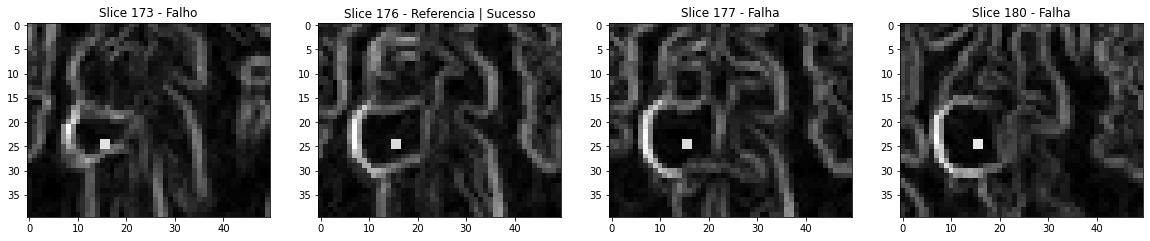

In [39]:
_, mri_preproc = slices_result
_, mri_preproc = slices_result
for i, mri in enumerate(mri_preproc):
    mri[y-1:y+1, x-1:x+1] = 50
    mri_preproc[i] = mri
plt.figure(figsize=(10, 10))
plt.figure(figsize=(20, 40))
plt.subplot(141)
plt.title('Slice 173 - Falho')
plt.imshow(mri_preproc[0][60:100, 100:150], cmap='gray')
plt.subplot(142)
plt.title('Slice 176 - Referencia | Sucesso')
plt.imshow(mri_preproc[3][60:100, 100:150], cmap='gray')
plt.subplot(143)
plt.title('Slice 177 - Falha')
plt.imshow(mri_preproc[4][60:100, 100:150], cmap='gray')
plt.subplot(144)
plt.title('Slice 180 - Falha')
plt.imshow(mri_preproc[7][60:100, 100:150], cmap='gray')


A etapa de pré-processamento é extremamente importante para o método watershed, pois a imagem precisa ter características que permitam seu funcionamento a partir de uma lógica topológica, isto é, ter mínimos delimitados por bordas bem definidas e fechadas. No caso da imagem referência, o pré-processamento executado foi suficiente para delimitar a região de interesse numa bacia bem definida, demostrando também conseguir tal efeito nos _slices_ anteriores. Contudo, quando analisamos o _slice_ 177 e 180, por exemplo, percebemos que o pré-processamento não obteve um resultado satisfatório, deixando uma região vazada e sem borda. Esse tipo de característica permite a inundação realizada pelo método watershed se espalhar para regiões adjacentes, causando a falha na segmentação como visualizada nos resultados das respectivas máscaras de segmentação.

Neste caso, para as imagens seguintes ao _slice_ 177, se faria necessário uma nova exploração dos métodos de pré-processamento, que conseguissem obter bordas bem definidas para os _slices_ posteriores. 

Referente ao _slice_ 173,  resultado anterior ao _slice_ de referência, uma possível explicação para a falha foi a diminuição significativa da lesão neste primeiro slice quando comparada com o slice de referência. Desta forma, o marcado (_seed_) encontra-se numa região muito próxima a borda, ou até mesmo sobrepondo-a, acarretando a segmentação de uma região de apenas um pequeno ponto na imagem

Por fim, apresentamos os índices Dice para cada máscara segmentada comparada com sua respectiva máscara _groundtruth_. As máscaras referêntes aos _slices_ 174-176 alcançaram valores elevados, próximos a similaridade total. Contudo, os casos falhos apresentaram valores próximos a total dissimilaridade.

In [40]:
i = 0
s_start, s_end = slices_range
for s in range(s_start, s_end):
    print(f'Slice {s} dice score: {dices_water[i]:0.4f}')
    i += 1

Slice 173 dice score: 0.0222
Slice 174 dice score: 0.9339
Slice 175 dice score: 0.9424
Slice 176 dice score: 0.9515
Slice 177 dice score: 0.0310
Slice 178 dice score: 0.0374
Slice 179 dice score: 0.1161
Slice 180 dice score: 0.2134
Slice 181 dice score: 0.0360


_________________
### Caso 2

O caso de teste 2 exibe um caso onde uma lesão de interesse encontra-se adjacente a uma grande área também resultado de uma extração, e portanto com aspectos visuais e característicos semelhantes, mas não sendo o alvo da segmentação. Para este caso de teste, a imagem MRI foi preprocessada elevando ao máximo valor de intensidade (255) os pixeis com valores superiores ao _threshold_ de 19, seguido por redução de ruído com um filtro de média, dois processos morfológicos de _closing_, primeiro com um elemento estruturante retangular e um segundo com um elemento de disco, e, por fim, um filtro de gradiente. 

Os demais parâmetros e resultados são exibidos a seguir:

Id do Subject: 0317
Intervalo de slices: (173, 182)
Perspectiva dos slices: a
Threshold de pré-processamento: 19
Pré-processamentos definidos e seus respectivos parametros:
   Pré-processamento: denoise_1
   Parametros:
    {'method': <function mean at 0x7f49405ffee0>, 'se': array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)}
   Pré-processamento: closing_1
   Parametros:
    {'method': <function closing at 0x7f494087b430>, 'se': array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)}
   Pré-processamento: closing_2
   Parametros:
    {'method': <function closing at 0x7f494087b430>, 'se': array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)}
   Pré-processamento: gradient_1
   Parametros:
    {'method': <function gradient at 0x7f49405ffca0>, 'se': array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)}
Coordanada X da semente: 155
Coordanada Y da semente: 103
Coordanada X da semente externa: 109
Coordanada Y da semente: 99

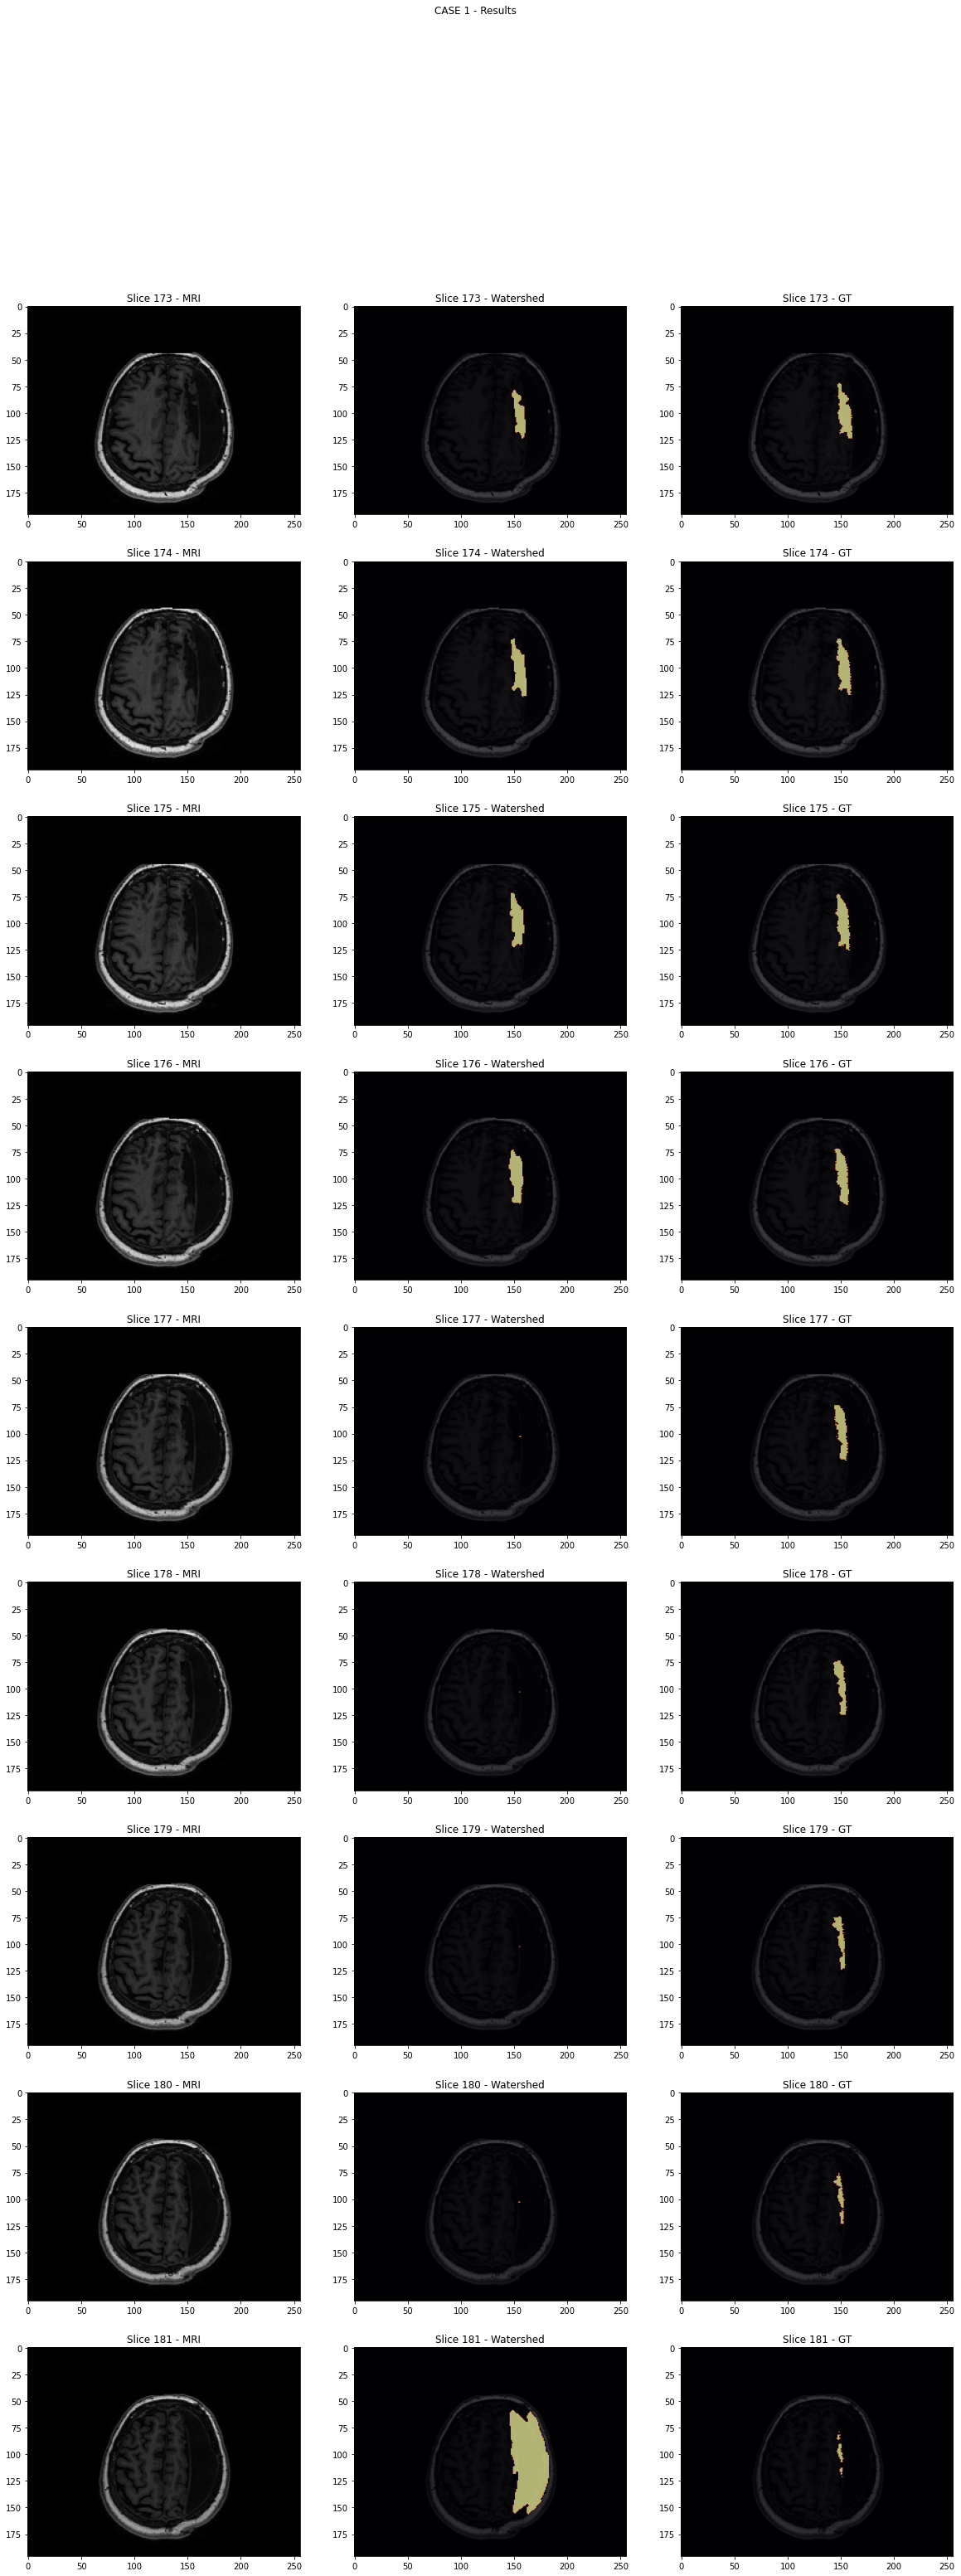

In [41]:
n_case = 1
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
norm_thres = case_test['norm_thres']
morphy = case_test['apply_morphy']
x = case_test['x']
y = case_test['y']
outer_x = case_test['outer_mark_x']
outer_y = case_test['outer_mark_y']

print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Threshold de pré-processamento: {norm_thres}')
print(f'Pré-processamentos definidos e seus respectivos parametros:')
for key in morphy:
    print(f'   Pré-processamento: {key}')
    print(f'   Parametros:\n    {morphy[key]}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')
print(f'Coordanada X da semente externa: {outer_x}')
print(f'Coordanada Y da semente: {outer_y}')

res_dict = {}
slices_result, dices_water = apply_batch_watershed(df, sub_id, slices_range,
                                    perspective, norm_thres, morphy, x,
                                    y, outer_x, outer_y, n_case)
dices_scores_watershed.append(dices_water)
res_dict[f'CASE{n_case}'] = {'watershed': dices_water}


Neste caso de testes, o _slice_ de referência para definição dos pré-processamentos foi o _slice_ de número 175. É possível observar que o _slice_ anterior, e diversos _slices_ posteriores apresentaram resultados satisfatórios com a utilização dos mesmos parâmetros, se assemelhando bastante a máscara humana. Porém, a partir do _slice_ 177 a segmentação começa a apresentar resultados falhos, inicialmente praticamente não segmentando nenhuma região, e, por fim, segmentando uma área adjacente de não interesse. 

Abaixo são apresentados, como feito anteriormente, detalhes da imagem de pré-processamento para o caso de referência e para os alguns casos falhos. 

<Figure size 720x720 with 0 Axes>

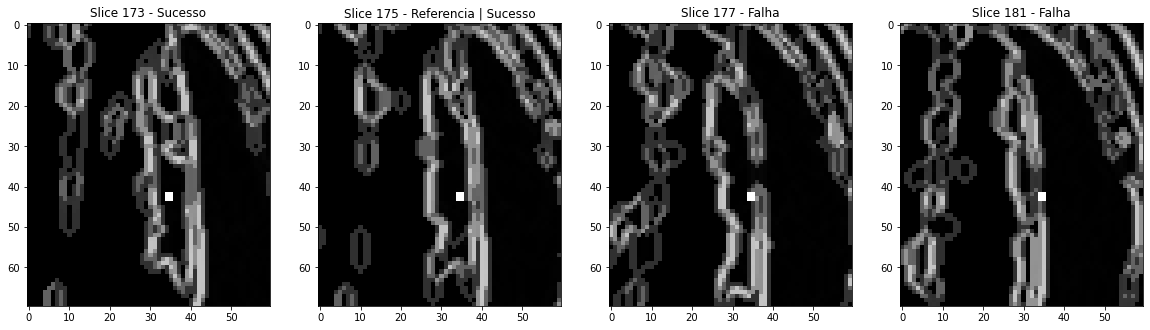

In [42]:
_, mri_preproc = slices_result
for i, mri in enumerate(mri_preproc):
    mri[y-1:y+1, x-1:x+1] = 255
    mri_preproc[i] = mri
plt.figure(figsize=(10, 10))
plt.figure(figsize=(20, 40))
plt.subplot(141)
plt.title('Slice 173 - Sucesso')
plt.imshow(mri_preproc[0][60:130, 120:180], cmap='gray')
plt.subplot(142)
plt.title('Slice 175 - Referencia | Sucesso')
plt.imshow(mri_preproc[2][60:130, 120:180], cmap='gray')
plt.subplot(143)
plt.title('Slice 177 - Falha')
plt.imshow(mri_preproc[4][60:130, 120:180], cmap='gray')
plt.subplot(144)
plt.title('Slice 181 - Falha')
plt.imshow(mri_preproc[7][60:130, 120:180], cmap='gray')

Para o caso do _slice_ 173 e 175, respectivamente, _slice_ anterior e slice de referência, o marcador ficou localizado em região centralizada da área de interesse. Adicionalmente, a região de interesse ficou bem definida e delimitada, não possuindo furos ou falhas. Contudo, o _slice_ 177 (e posteriores) e o _slice_ 181 apresentaram configurações diferentes. Para o _slice_ 177, a lesão inicia uma modificação em sua forma, de maneira que o marcador outrora centralizado passa a se encontrar numa região de borda, acarretando uma segmentação de apenas um ponto semelhante a poucos pixeis nos resultados. Ainda, mesmo que numa região centralizada, é possível perceber que a segmentação seria falha e apresentaria vazamento para outra região adjacente, dada a falha lateral na região da borda. 

Já para o caso do _slice_ 181, a região de interesse já apresenta forma totalmente distinta da apresentada no _slice_ de referência. O marcador agora se encontra posicionado na região adjacente, e as bordas encontram-se mal definidas, resultado assim na segmentação da região adjacente e na região de interesse, assim como do restante da área central do hemisfério cerebral, como um único segmento, resultado apresentado no último _slice_ desde caso.

Novamente, diversas máscaras apresentaram resultados bastante aproximados do _groundtruth_ no caso 2, com índices de até 0.88 de similaridade. Contudo, os casos falhos apresentaram resultados totalmente dissimilares com valores de 0.0, sendo estes os casos onde é possível notar a inexistência de máscaras de segmentação.

In [43]:
i = 0
s_start, s_end = slices_range
for s in range(s_start, s_end):
    print(f'Slice {s} dice score: {dices_water[i]:0.4f}')
    i += 1

Slice 173 dice score: 0.8338
Slice 174 dice score: 0.8375
Slice 175 dice score: 0.8832
Slice 176 dice score: 0.8804
Slice 177 dice score: 0.0050
Slice 178 dice score: 0.0000
Slice 179 dice score: 0.0000
Slice 180 dice score: 0.0000
Slice 181 dice score: 0.0619


_____________
### Caso 3

No caso de teste 3 se adotou como referência o _slice_ 167. Este caso de teste apresentou problemas nos _slices_ adjacentes, tanto anteriores como posteriores, com grandes vazamentos da região segmentada. Para o caso 3, pixeis acima do valor limiar de 20 foram saturados para o valor 255, posteriormente aplicando-se uma redução de ruído com média, e um filtro de gradiente. 

Demais parâmetros e resultados são apresentados a seguir:

Id do Subject: 0023
Intervalo de slices: (165, 172)
Perspectiva dos slices: a
Threshold de pré-processamento: 20
Pré-processamentos definidos e seus respectivos parametros:
   Pré-processamento: denoise_1
   Parametros:
    {'method': <function mean at 0x7f49405ffee0>, 'se': array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)}
   Pré-processamento: gradient_1
   Parametros:
    {'method': <function gradient at 0x7f49405ffca0>, 'se': array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)}
   Pré-processamento: closing_1
   Parametros:
    {'method': <function closing at 0x7f494087b430>, 'se': array([[1]], dtype=uint8)}
Coordanada X da semente: 143
Coordanada Y da semente: 143
Coordanada X da semente externa: 109
Coordanada Y da semente: 99


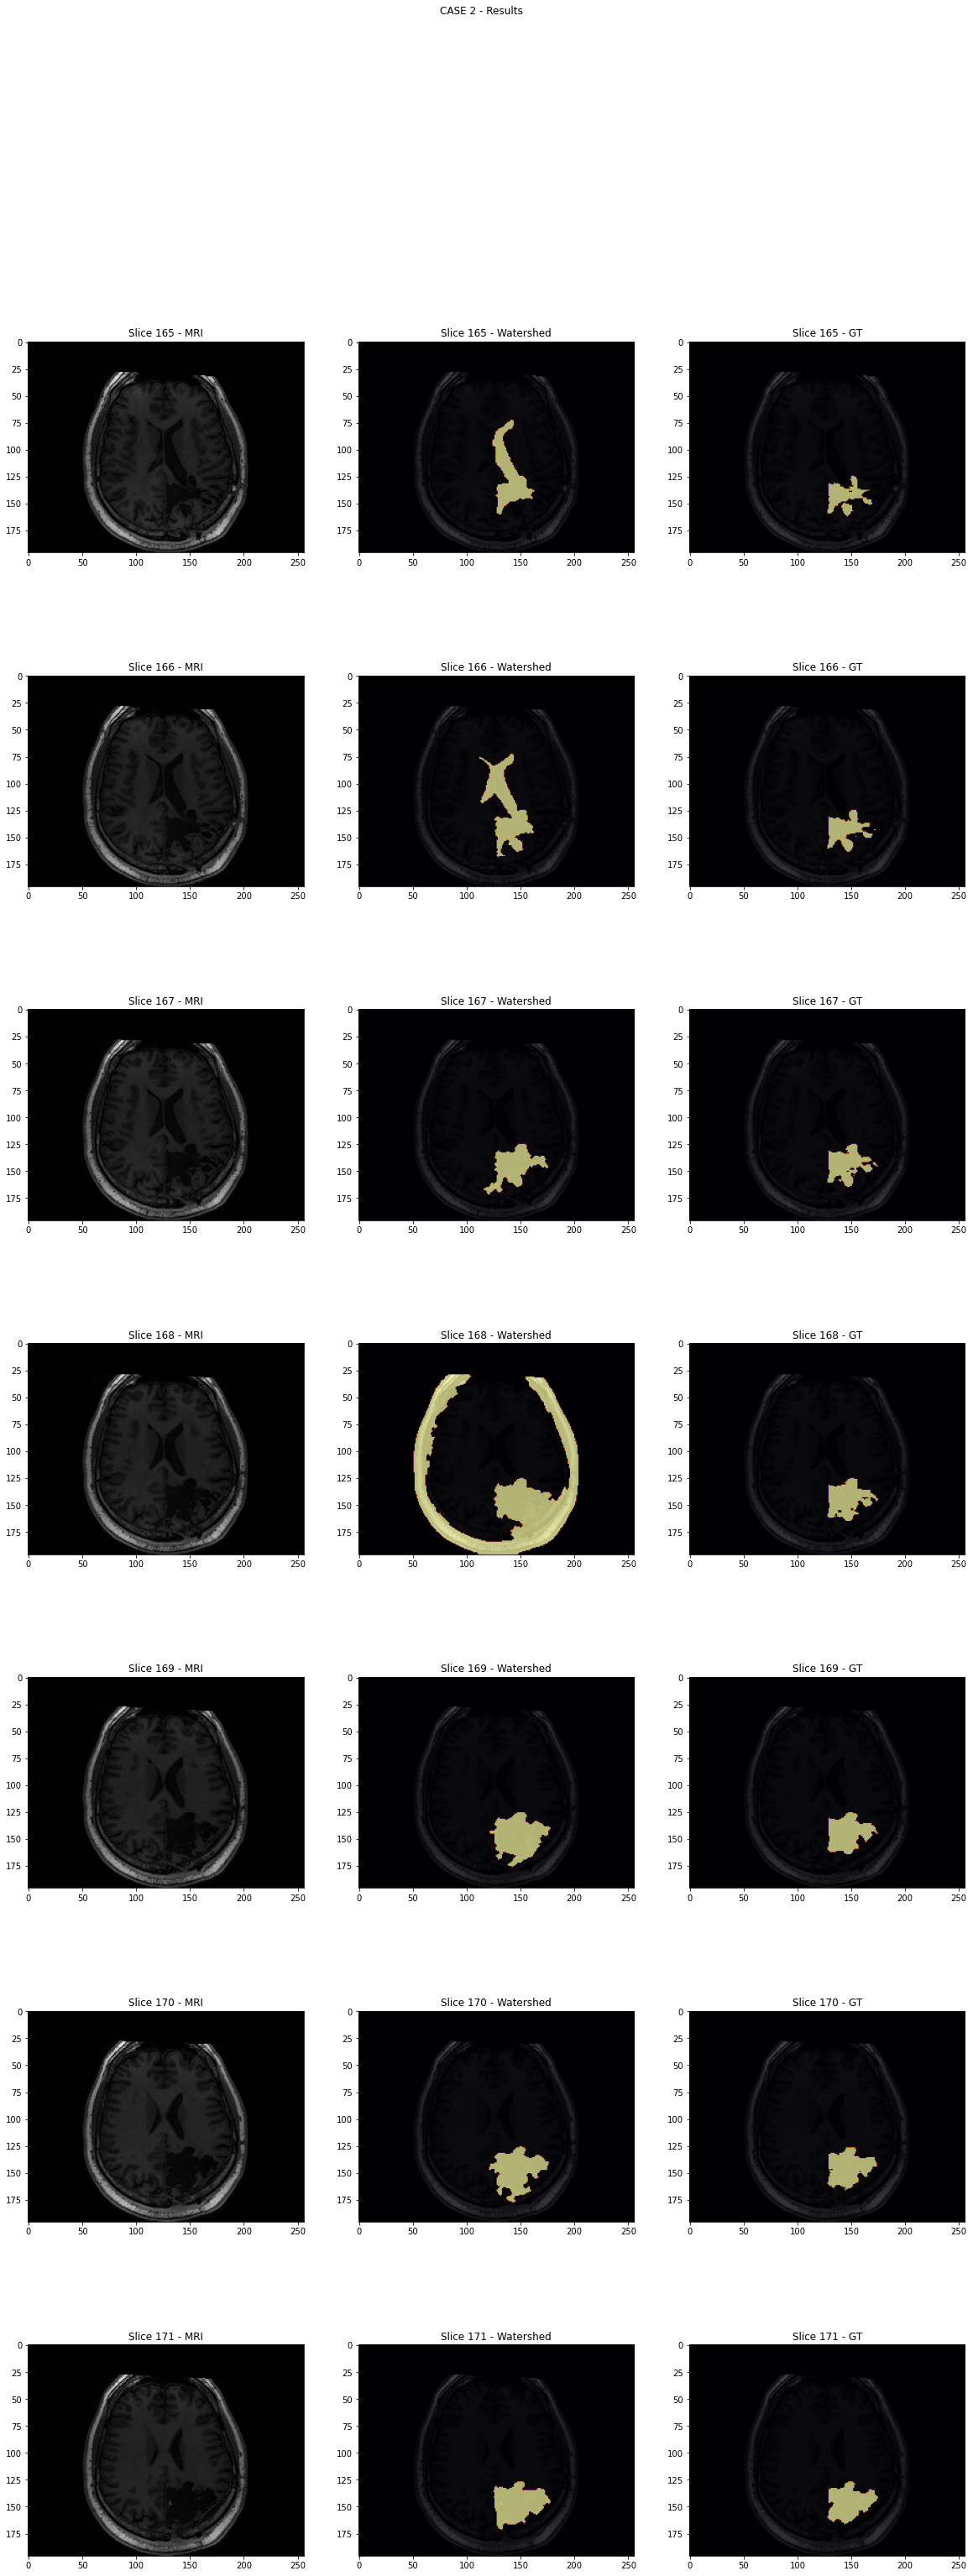

In [44]:
n_case = 2
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
norm_thres = case_test['norm_thres']
morphy = case_test['apply_morphy']
x = case_test['x']
y = case_test['y']
outer_x = case_test['outer_mark_x']
outer_y = case_test['outer_mark_y']

print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Threshold de pré-processamento: {norm_thres}')
print(f'Pré-processamentos definidos e seus respectivos parametros:')
for key in morphy:
    print(f'   Pré-processamento: {key}')
    print(f'   Parametros:\n    {morphy[key]}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')
print(f'Coordanada X da semente externa: {outer_x}')
print(f'Coordanada Y da semente: {outer_y}')

res_dict = {}
slices_result, dices_water = apply_batch_watershed(df, sub_id, slices_range,
                                    perspective, norm_thres, morphy, x,
                                    y, outer_x, outer_y, n_case)
dices_scores_watershed.append(dices_water)
res_dict[f'CASE{n_case}'] = {'watershed': dices_water}


A seguir são apresentados detalhes para análise de casos de falha e de sucesso.

<Figure size 720x720 with 0 Axes>

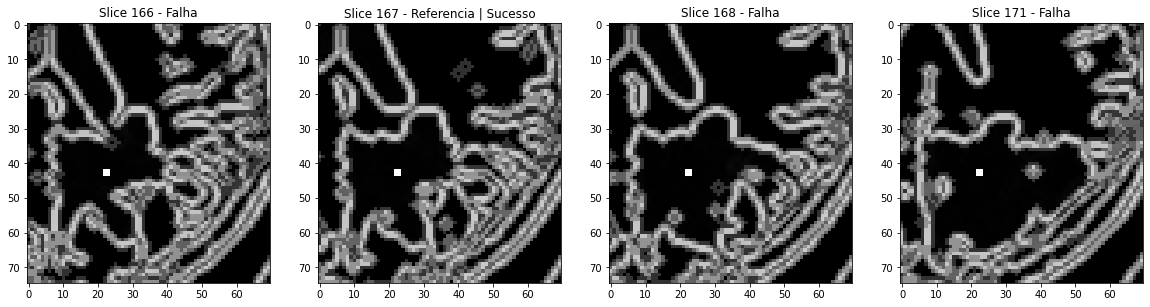

In [45]:
_, mri_preproc = slices_result
for i, mri in enumerate(mri_preproc):
    mri[y-1:y+1, x-1:x+1] = 255
    mri_preproc[i] = mri
plt.figure(figsize=(10, 10))
plt.figure(figsize=(20, 40))
plt.subplot(141)
plt.title('Slice 166 - Falha')
plt.imshow(mri_preproc[1][100:175, 120:190], cmap='gray')
plt.subplot(142)
plt.title('Slice 167 - Referencia | Sucesso')
plt.imshow(mri_preproc[2][100:175, 120:190], cmap='gray')
plt.subplot(143)
plt.title('Slice 168 - Falha')
plt.imshow(mri_preproc[3][100:175, 120:190], cmap='gray')
plt.subplot(144)
plt.title('Slice 171 - Falha')
plt.imshow(mri_preproc[6][100:175, 120:190], cmap='gray')

O _slice_ 173, imediatamente anterior ao _slice_ de referência, apresenta uma segmentação falha com transbordamento da segmentação para uma região de não interesse. É possível perceber na imagem que a área de interesse não esta completamente isolada, tendo uma região da borda que se une com a região do _corpus callosum_ (região escura no centro do cérebro). 

Já o _slice_ 174, utilizado como referência para definição dos métodos de preprocessamento, a segmentação foi bem-sucedida e se aproximou do _groundtruth_. Nesta, a região de interesse está bem definida por bordas claras e contínuas. 

O _slice_ 177 apresenta falha, também com segmentação de áreas de não interesse. Devido a uma junção das bordas da área de interesse com bordas da região do osso craniano, a segmentação incluiu toda a região do perímetro do crânio. Observando a máscara de _groundtruth_, é possível verificar que a região da lesão possui uma delimitação não bem definida, inclusive se mesclando em uma de suas extremidades com regiões cerebrais de aspecto semelhante, sendo um caso de extrema dificuldade e até mesmo impossível de segmentar de maneira automática. 

Por fim, no _slice_ 181 o método retorna a apresentar um resultado significativo, tendo uma área bem definida e uma segmentação satisfatória, prosseguindo até o último _slice_ considerado

Os melhores resultados no caso de teste 3 alcançaram até 0.87 de índice de similaridade. Os casos falhos oscilaram entre cerca de 0.55 de similaridade e 0.24 no pior caso. Neste último, o caso é especialmente difícil devido a característica da lesão não possuir delimitações claras com regiões muito semelhantes, mas de origem diferente da lesão.

In [46]:
i = 0
s_start, s_end = slices_range
for s in range(s_start, s_end):
    print(f'Slice {s} dice score: {dices_water[i]:0.4f}')
    i += 1

Slice 165 dice score: 0.5514
Slice 166 dice score: 0.5657
Slice 167 dice score: 0.8312
Slice 168 dice score: 0.2455
Slice 169 dice score: 0.8141
Slice 170 dice score: 0.8609
Slice 171 dice score: 0.8753


_______________
### Caso de teste 4
Por fim, o último caso de teste avaliado possui uma região de interesse proxima a uma região com características similares, separados por uma fina borda. Para este caso, o _slice_ de referência foi o de número 117

Id do Subject: 0035
Intervalo de slices: (114, 120)
Perspectiva dos slices: a
Threshold de pré-processamento: 50
Pré-processamentos definidos e seus respectivos parametros:
   Pré-processamento: denoise_1
   Parametros:
    {'method': <function median at 0x7f494062b280>, 'se': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)}
   Pré-processamento: closing_1
   Parametros:
    {'method': <function closing at 0x7f494087b430>, 'se': array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

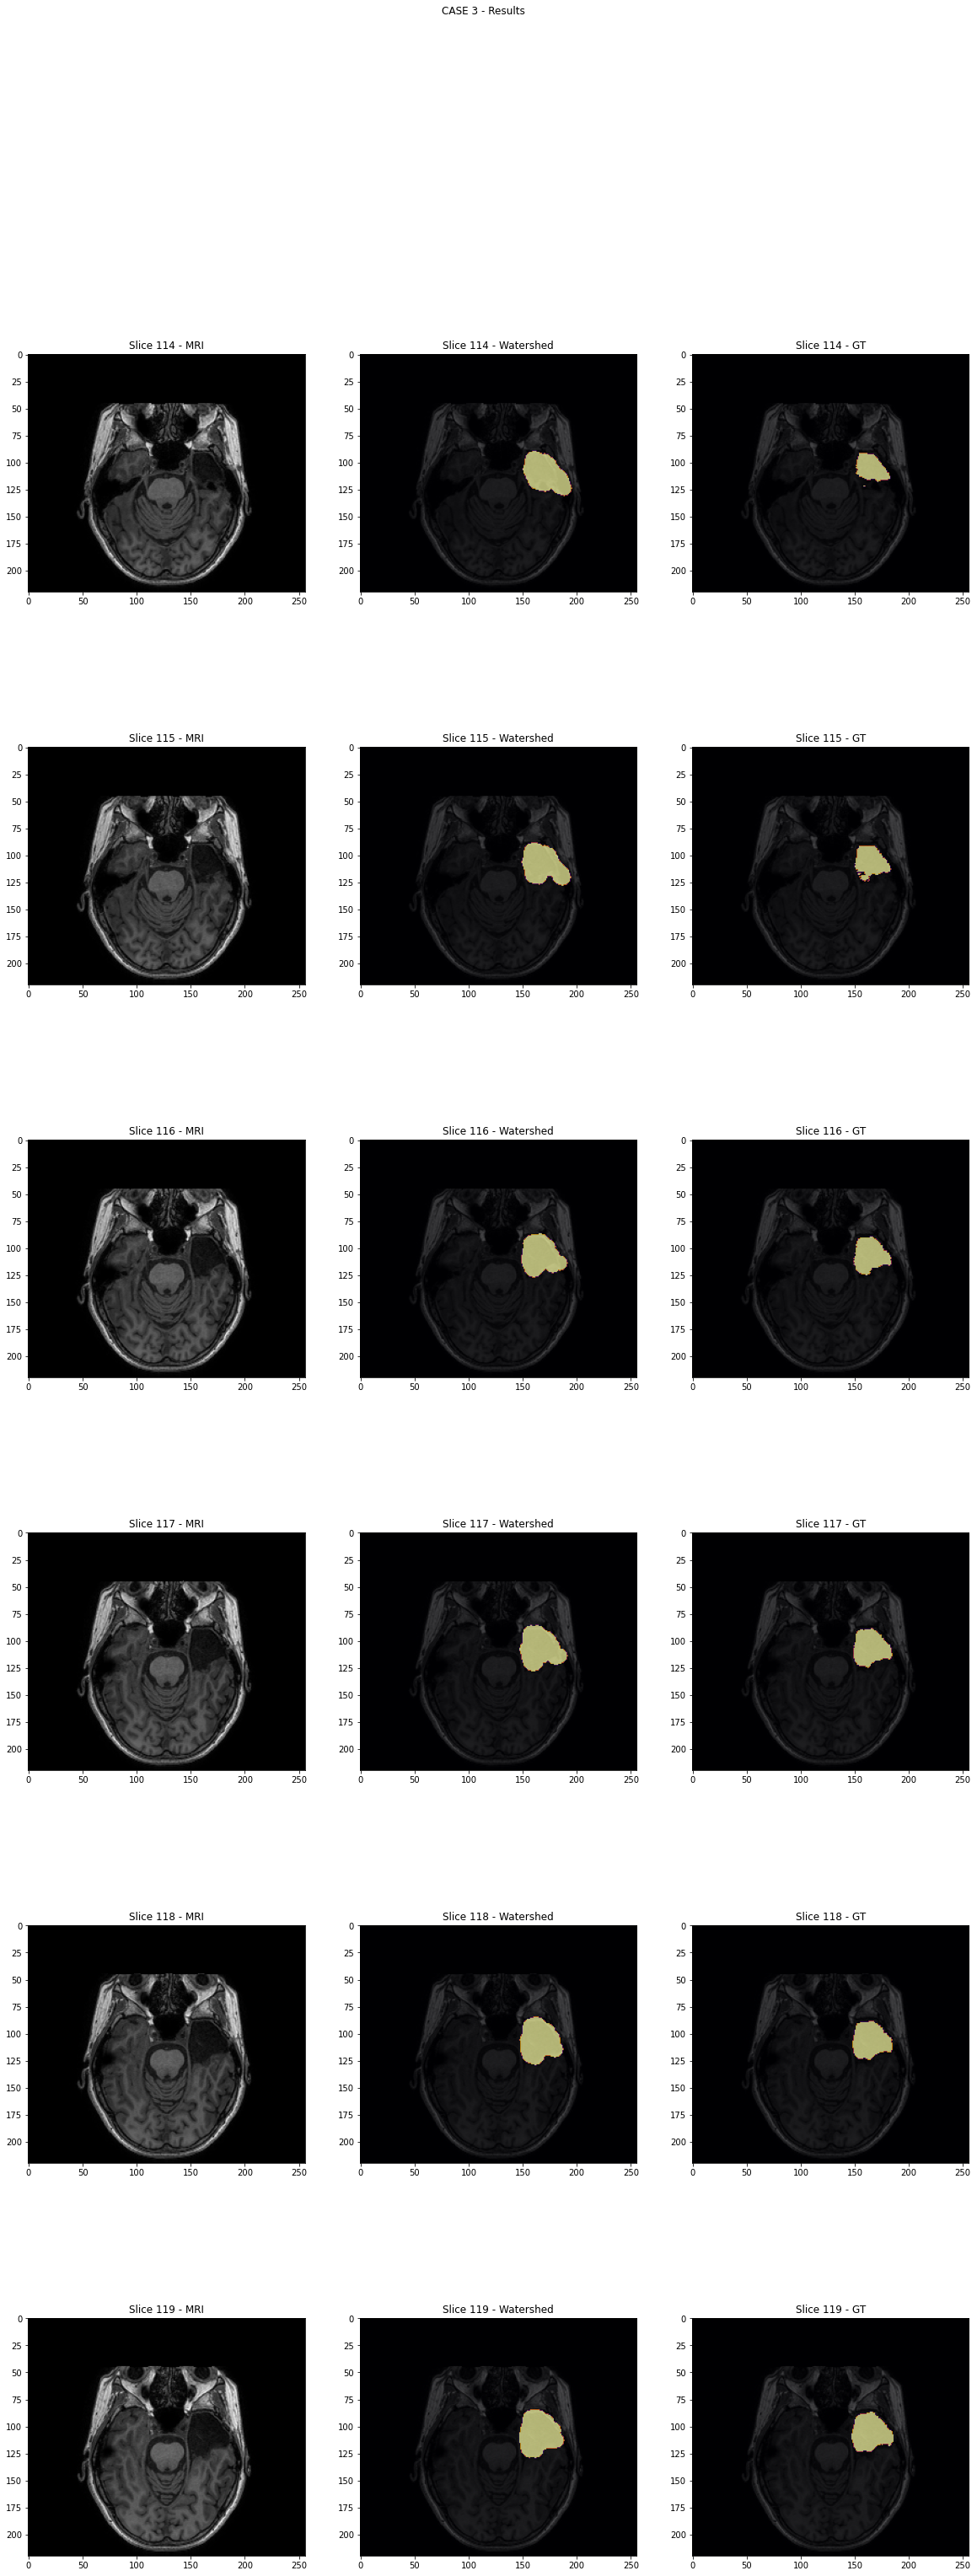

In [47]:
n_case = 3
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
norm_thres = case_test['norm_thres']
morphy = case_test['apply_morphy']
x = case_test['x']
y = case_test['y']
outer_x = case_test['outer_mark_x']
outer_y = case_test['outer_mark_y']

print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Threshold de pré-processamento: {norm_thres}')
print(f'Pré-processamentos definidos e seus respectivos parametros:')
for key in morphy:
    print(f'   Pré-processamento: {key}')
    print(f'   Parametros:\n    {morphy[key]}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')
print(f'Coordanada X da semente externa: {outer_x}')
print(f'Coordanada Y da semente: {outer_y}')

res_dict = {}
slices_result, dices_water = apply_batch_watershed(df, sub_id, slices_range,
                                    perspective, norm_thres, morphy, x,
                                    y, outer_x, outer_y, n_case)
dices_scores_watershed.append(dices_water)
res_dict[f'CASE{n_case}'] = {'watershed': dices_water}

O caso de testes 4 obteve bons resultados em todos os _slices_ submetidos ao processo de segmentação. Como é possível observar, os segmentos apresentaram formato compatível com a região de interesse e tamanho aproximado, em alguns casos abrangindo uma área maior do que o da máscara _groundtruth_. 

O caso 4 apresentou resultados equilibrados entre todos os slices, oscilando entre 0.63 no pior caso e 0.86 nos casos de maior similaridade. A uniformidade entre os segmentos e os resultados semelhantes podem ser confirmados pela análise visual realizada anteriormente. 

In [48]:
i = 0
s_start, s_end = slices_range
for s in range(s_start, s_end):
    print(f'Slice {s} dice score: {dices_water[i]:0.4f}')
    i += 1

Slice 114 dice score: 0.6396
Slice 115 dice score: 0.7304
Slice 116 dice score: 0.8243
Slice 117 dice score: 0.8388
Slice 118 dice score: 0.8640
Slice 119 dice score: 0.8652


_______________
## Conclusão

Como observado, o Watershed apresentou em diversos casos resultados satisfatórios nas máscaras segmentadas, se aproximando consideravelmente das máscaras feitas por um humano. Considerando o trabalhoso processo de segmentar tais regiões de interesse, ainda mais considerando a necessidade de repetição deste processo ao longo de diversos _slices_, um método automatizado que auxilie neste processo se mostra bastante pertinente. 

Contudo, o método de segmentação Watershed requer etapas de preprocessamento não triviais, principalmente considerando usuários sem o conhecimento específico, como método para redução de ruído, processamento morfológico, entre outros, reduzindo a aplicabilidade prática. Ainda, verificou-se nos casos explorados neste projeto que, por vezes, os preprocessamentos definidos e adequados para um _slice_ de referência nem sempre se mantém adequados para uma quantidade miníma esperada de _slices_ adjacentes.

Em suma, acreditamos que o método, apesar de limitações, pode auxiliar o processo em casos mais simples e, mesmo em casos considerados falhos, as segmentações geralmente ainda cobrem a região de interesse e poderiam ser corrigidas em processos posteriores, exigindo menos trabalho final do usuário humano.